#ATIVIDADE 2 - Redes Recorrentes
# DUPLA:
## - DANIEL ELBACHÁ MARNET
## - IGOR VILAS BOAS SILVEIRA 

### A atividade é prever para as próximas 6h o valor da concentração de PM2.5. 

Utilize os conceitos aprendidos até aqui, testando diferentes modelos de IA e diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.

1. Inicialmente, escolha uma estação de monitoramento de uma das cidades com que irá trabalhar, e faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam.
2. Explore as técnicas MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM, utilizando a camada TimeDistributed, quando julgarem necessário;
3. Escolha, com base na avaliação do loss e das métricas MAE, MSE, NMSE, r, R2 e Fac2 qual foi o melhor modelo, apresentando por hora e também na média final das 6h;
4. Use o ano de 2015 para fins de teste;
5. Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor;

Importante1: Para cada 24h de entrega em atraso, serão descontados 25% da nota. <br>
Importante2: O trabalho deve ser feito em **dupla**. <br>
Importante3: BÔNUS! Quem conseguir utilizar as informações meteorológicas para melhorar a qualidade dos modelos finais, ganhará um bônus na nota final; idem para a utilização de wavelets para feature augmentation. <br>



Neste exercício, foi solicitado construir um preditor de séries temporais e treiná-lo para prever uma única série temporal. 

Usaremos um conjunto de dados fornecido pelo [UCI Machine Learning Repository] (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) que possui dados de monitoramento da qualidade do ar nas cidades chinesas / distritos. Os dados se referem a concentração de material particulado de diametro menor que 2,5 micrometros (PM2.5), que são as partículas finas inaláveis pelo ser humano e perigosas a saúde. O período de monitoramento é de 01/01/2010 a 31/12/2015. Dados faltantes são denotados como NaN.

Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220 to 10236, [Web Link].


# Imports

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, MaxPooling3D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


## Carregamento e Tratamento dos Dados Faltantes

In [2]:
# carregar o dataset
df_GuangzhouPM20100101_20151231 = pd.read_csv('https://drive.google.com/uc?export=view&id=1u1rOrMSMu9xY4zPzN0cIeFtE2EnWlVBI')
df0 = df_GuangzhouPM20100101_20151231
df0

,No,year,month,day,hour,season,PM_City Station,PM_5th Middle School,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4.0,NaN,NaN,NaN,9.4,76.0,1015.100000,13.5,NW,0.8,0.0,0.0
1,2,2010,1,1,1,4.0,NaN,NaN,NaN,10.2,83.0,1015.200000,13.0,cv,0.5,0.0,0.0
2,3,2010,1,1,2,4.0,NaN,NaN,NaN,10.4,87.0,1015.000000,12.5,NW,0.6,0.3,0.3
3,4,2010,1,1,3,4.0,NaN,NaN,NaN,10.2,89.0,1014.900000,12.0,NW,1.4,0.6,0.9
4,5,2010,1,1,4,4.0,NaN,NaN,NaN,10.4,91.0,1014.600000,11.8,NE,0.6,0.7,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4.0,59.0,56.0,59.0,11.0,80.0,1018.299988,14.4,NW,10.9,0.0,0.0
52580,52581,2015,12,31,20,4.0,58.0,57.0,58.0,11.4,82.0,1018.700012,14.5,NW,12.9,0.0,0.0
52581,52582,2015,12,31,21,4.0,60.0,56.0,60.0,11.1,78.0,1019.300000,14.9,NW,14.7,0.0,0.0
52582,52583,2015,12,31,22,4.0,60.0,57.0,60.0,10.4,75.0,1019.500000,14.8,NW,15.9,0.0,0.0


In [3]:
df = df0.iloc[:, [6,9,10,11,12,14,15,16]] # Vamos selecionar os dados apenas da coluna 6, referente aos dados de poluição da estação "PM_City Station"
df

,PM_City Station,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
0,NaN,9.4,76.0,1015.100000,13.5,0.8,0.0,0.0
1,NaN,10.2,83.0,1015.200000,13.0,0.5,0.0,0.0
2,NaN,10.4,87.0,1015.000000,12.5,0.6,0.3,0.3
3,NaN,10.2,89.0,1014.900000,12.0,1.4,0.6,0.9
4,NaN,10.4,91.0,1014.600000,11.8,0.6,0.7,1.6
...,...,...,...,...,...,...,...,...
52579,59.0,11.0,80.0,1018.299988,14.4,10.9,0.0,0.0
52580,58.0,11.4,82.0,1018.700012,14.5,12.9,0.0,0.0
52581,60.0,11.1,78.0,1019.300000,14.9,14.7,0.0,0.0
52582,60.0,10.4,75.0,1019.500000,14.8,15.9,0.0,0.0


In [5]:
index_valido = df.first_valid_index() # Seleção dos dados a partir do primeiro não nulo
df = df.iloc[index_valido:] # ajuste do index dos dados

# interpolando os dados
#df = df.interpolate()
df = df.dropna()
df.head()

,PM_City Station,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
16549,48.0,13.9,64.0,1013.9,21.0,10.9,0.0,0.0
16550,63.0,13.8,67.0,1012.7,20.1,3.7,0.0,0.0
16551,71.0,14.3,68.0,1012.3,20.4,6.5,0.0,0.0
16552,79.0,14.5,68.0,1012.0,20.6,9.3,0.0,0.0
16553,78.0,14.2,69.0,1012.2,20.1,2.2,0.0,0.0


In [6]:
df.isnull().sum() # Visualição da quantidade de dados faltantes

PM_City Station    0
DEWP               0
HUMI               0
PRES               0
TEMP               0
Iws                0
precipitation      0
Iprec              0
dtype: int64

In [7]:
df.describe() # avaliando estatisticamente

,PM_City Station,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
count,36035.000000,36035.000000,36035.000000,36035.000000,36035.000000,36035.000000,36035.000000,36035.000000
mean,49.071139,16.229097,77.014569,1004.879326,21.761998,8.079514,0.239553,1.008786
std,36.899914,105.775458,107.473065,6.938497,6.753501,12.632118,1.845806,5.871165
min,1.000000,-9999.000000,-9999.000000,975.000000,1.700000,0.000000,0.000000,0.000000
25%,22.000000,12.400000,68.000000,999.400000,16.900000,2.000000,0.000000,0.000000
50%,41.000000,19.200000,82.000000,1004.900000,23.200000,4.100000,0.000000,0.000000
75%,66.000000,23.700000,92.000000,1010.300000,26.600000,9.100000,0.000000,0.000000
max,526.000000,27.400000,100.000000,1023.100000,37.400002,214.300000,90.400002,126.000002


In [8]:
data = df.values # mudança do tipo de dados para numpy.ndarray
data = data.astype('float32')
print('Quantidade de dados no arquivo:',len(data))
data

Quantidade de dados no arquivo: 36035


array([[48. , 13.9, 64. , ..., 10.9,  0. ,  0. ],
       [63. , 13.8, 67. , ...,  3.7,  0. ,  0. ],
       [71. , 14.3, 68. , ...,  6.5,  0. ,  0. ],
       ...,
       [60. , 11.1, 78. , ..., 14.7,  0. ,  0. ],
       [60. , 10.4, 75. , ..., 15.9,  0. ,  0. ],
       [63. , 10.4, 75. , ..., 15.9,  0. ,  0. ]], dtype=float32)

## Visualizando os Dados

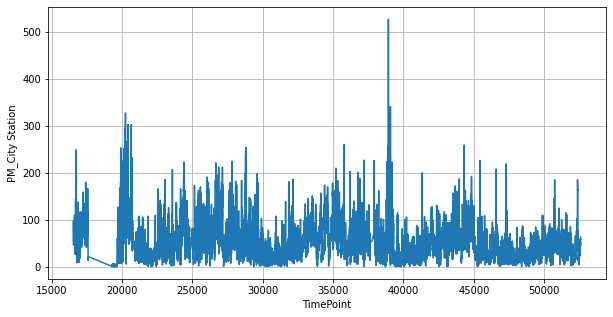

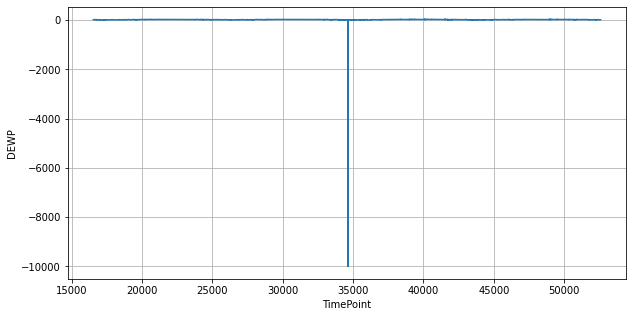

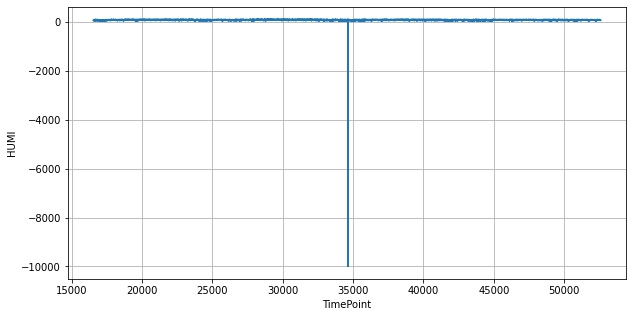

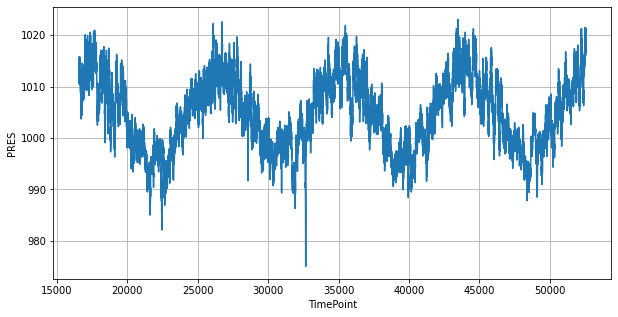

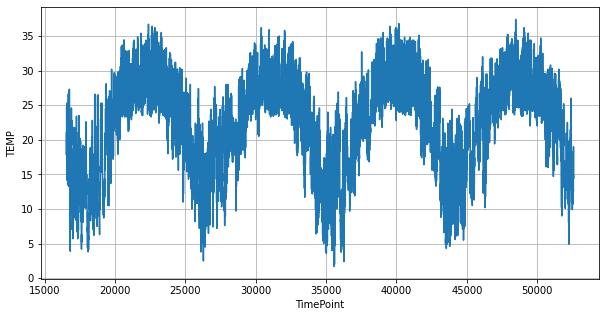

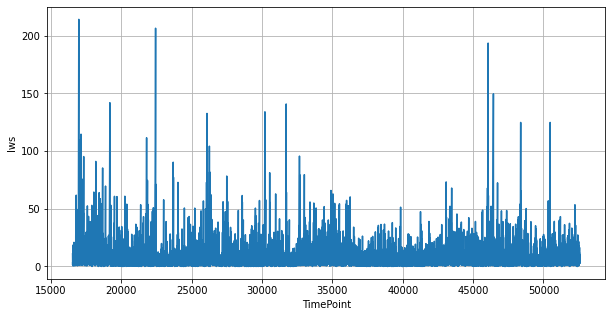

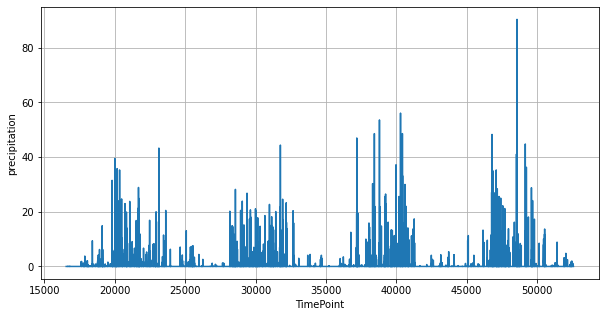

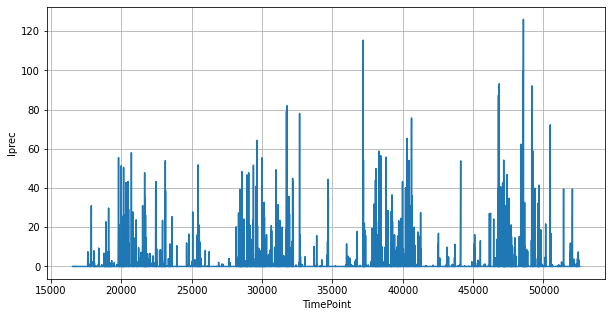

In [14]:
for i in range(df.shape[1]):
  plt.figure(figsize=[10,5])
  plt.xlabel('TimePoint')
  plt.ylabel(df.columns[i])
  plt.grid()
  plt.plot(df.iloc[:,i:i+1])
  plt.show()

## Seleção dos dados para teste

Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste, a partir do ano de 2015.

In [15]:
df_test = df0.loc[(df0["year"]) == 2015]
test_size = len(df_test)  # tamanho dos dados a partir de 2015
test_size

8760

In [16]:
# split into train and test sets
train_size = (len(data) - test_size)

# dados de treino e teste
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Dataset de treinamento contém: ', len(train),' dados')

split_size = len(test)/len(train)
print('Dataset de teste contém: ', len(test),' dados: ', int(split_size*100), "% do total")


data.shape

Dataset de treinamento contém:  27275  dados
Dataset de teste contém:  8760  dados:  32 % do total


(36035, 8)

Os LSTMs são sensíveis à escala dos dados de entrada, especificamente quando as funções de ativação sigmóide ou tanh são usadas. É fundamental normalizar os dados para o intervalo de [0, 1]. Isso pode ser feito usando a classe de pré-processamento MinMaxScaler da biblioteca scikit-learn.

In [17]:
# Uso do MinMaxScaler para normalizar o conjunto de treinamento e testes entre 0 e 1.
scaler = MinMaxScaler(feature_range=(0, 1))

# normalize the dataset
data_train = scaler.fit_transform(data)
norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

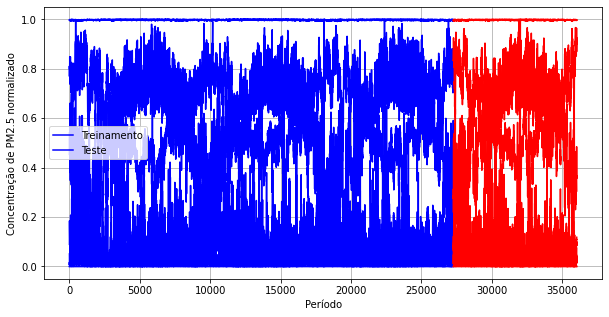

In [18]:
# Visualização dos dados normalizados de treino e teste
plt.figure(figsize=[10,5])
plt.xlabel('Período')
plt.ylabel('Concentração de PM2.5 normalizado')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Treinamento','Teste']);

# Predição de séries temporais utilizando redes neurais recorrentes


Aqui desenvolveremos duas redes neurais recorrentes, dos tipos simples, LSTM, GRU e CNN1D, utilizando o Keras, para demonstrar sua capacidade em prever séries temporais


### Definição de função para montagem do look_back

Podemos escrever uma função que separa os dados em um array de entrada (X) que tenha todo o dado no tempo t-i, e um array de saída que contenha os dados no momento t.

A função usa dois argumentos: os dados e o look_back, que é o número de timesteps anteriores a serem usados como variáveis de entrada para prever o próximo período de tempo - o padrão é 1.

In [21]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

## Look Back

In [22]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 50 # olha somente para a amostra anterior para prever a próxima amostra


## Ajuste do Shape

A RNN simples espera que os dados de entrada (X) sejam fornecidos na forma de: [sample, time steps, features].

Atualmente, os dados estão no formato: [samples, features], e estamos modelando o problema como um timestep para cada amostra. Usando numpy.reshape() da seguinte forma fazemos a devida transformação:

In [23]:
norm_train.shape

(27275, 8)

In [24]:
# # reshape a entrada para [samples, time steps, features]
def reshape_train_test(look_back, split_size):
    trainX_whole, trainY_whole = split_X_y(norm_train, look_back)
    testX, testY = split_X_y(norm_test, look_back)
    trainX_whole = np.reshape(trainX_whole, (trainX_whole.shape[0], look_back, data.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], look_back, data.shape[1]))

    # cria o dataset de validação
    trainX, valX, trainY, valY = train_test_split(trainX_whole, trainY_whole, test_size=split_size)
    return trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY

In [25]:
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, split_size)

print('Shape de trainX_whole', trainX_whole.shape)
print('Shape de x_train', trainX.shape)
print('Shape de x_val', valX.shape)
print('Shape de x_test', testX.shape)

print('Shape de trainY_whole', trainY_whole.shape)
print('Shape de y_train', trainY.shape)
print('Shape de y_val', valY.shape)
print('Shape de y_test', testY.shape)

ValueError: ignored

## Definição da função para plotagem dos resultados

Vamos agora definir uma função para fazer as previsões e plotar. 
Uma vez que o modelo estiver ajustado, podemos estimar o desempenho do modelo nos conjuntos de dados de treinamento e teste.

Observe que devemos inverter (desnormalizar) as previsões antes de calcular a acurácia para garantir que o desempenho seja comparado nas mesmas unidades que os dados originais (ppm por mês).

As previsões foram geradas usando o modelo para o conjunto de dados de treinamento e de teste. Também podemos visualizar os resultados para ter uma indicação de como o modelo funciona.

Ao plotar os dados, devemos deslocar as previsões pelo look_back no tempo para alinhar no eixo x com o conjunto de dados original. Os dados são apresentados com o conjunto de dados original como pontos pretos, as previsões para o conjunto de dados de treinamento em azul e as previsões no conjunto de dados de teste em vermelho.

In [ ]:
def plot_history_predictions(history, Xtrain, Ytrain, Xtest, Ytest, scaler, model, title, xlabel, ylabel, lookback):
    # Resumo do historico de loss
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
    plt.show()

    # faz as predições
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xtest)

    # inverte as predições
    if(len(trainPredict.shape)==3):
        trainPredict=trainPredict[:,-1,:]
        testPredict=testPredict[:,-1,:]
    trainPredict = scaler.inverse_transform(trainPredict)
    trainYTrue = scaler.inverse_transform(Ytrain)
    testPredict = scaler.inverse_transform(testPredict)
    testYTrue = scaler.inverse_transform(Ytest)

    # calcula o root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
    print('Treinamento: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
    print('Teste: %.2f RMSE' % (testScore))

    plt.figure(figsize=[20,5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(range(len(data)),data,'k.')
    plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
    plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
    plt.legend(['Original','Treinamento','Teste']);
    

# Rede MLP

In [ ]:
# cria e ajusta a MLP 
K.clear_session()
modelMLP = Sequential()
modelMLP.add(Dense(300, activation='linear', input_shape=(look_back,data.shape[1])))
modelMLP.add(Dense(100, activation='linear'))
modelMLP.add(Dense(50, activation='linear'))
modelMLP.add(Dense(1, activation='sigmoid'))

modelMLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50, 300)           600       
                                                                 
 dense_1 (Dense)             (None, 50, 100)           30100     
                                                                 
 dense_2 (Dense)             (None, 50, 50)            5050      
                                                                 
 dense_3 (Dense)             (None, 50, 1)             51        
                                                                 
Total params: 35,801
Trainable params: 35,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelMLP.compile(loss='mean_squared_error', optimizer='adam',
                    metrics=["MAE", "MSE"])

historyMLP = modelMLP.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=100, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
191/191 [==============================] - 3s 11ms/step - loss: 0.0040 - MAE: 0.0457 - MSE: 0.0040 - val_loss: 0.0039 - val_MAE: 0.0444 - val_MSE: 0.0039
Epoch 2/20
191/191 [==============================] - 2s 10ms/step - loss: 0.0040 - MAE: 0.0458 - MSE: 0.0040 - val_loss: 0.0039 - val_MAE: 0.0443 - val_MSE: 0.0039
Epoch 3/20
191/191 [==============================] - 2s 10ms/step - loss: 0.0040 - MAE: 0.0458 - MSE: 0.0040 - val_loss: 0.0039 - val_MAE: 0.0449 - val_MSE: 0.0039
Epoch 4/20
191/191 [==============================] - 2s 10ms/step - loss: 0.0040 - MAE: 0.0457 - MSE: 0.0040 - val_loss: 0.0040 - val_MAE: 0.0479 - val_MSE: 0.0040
Epoch 5/20
191/191 [==============================] - 2s 10ms/step - loss: 0.0040 - MAE: 0.0457 - MSE: 0.0040 - val_loss: 0.0039 - val_MAE: 0.0467 - val_MSE: 0.0039
Epoch 6/20
191/191 [==============================] - 2s 10ms/step - loss: 0.0040 - MAE: 0.0458 - MSE: 0.0040 - val_loss: 0.0039 - val_MAE: 0.0449 - val_MSE: 0.0039
Epoch 7/20

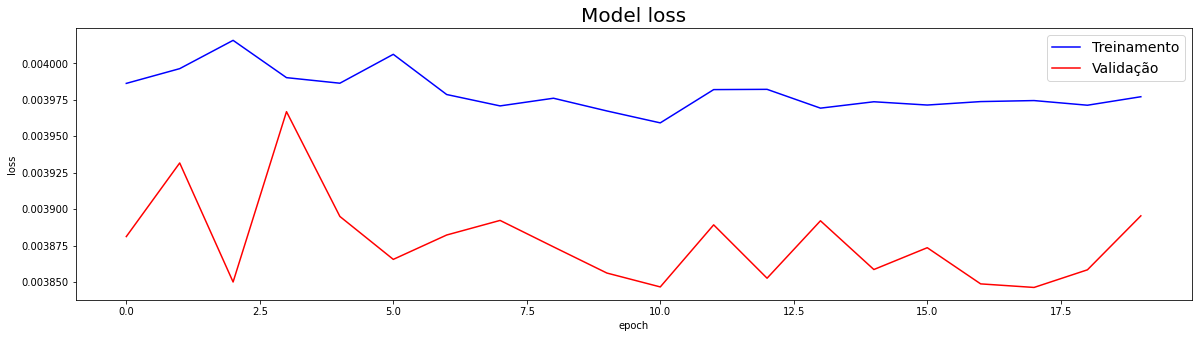

Treinamento: 23.95 RMSE
Teste: 19.14 RMSE


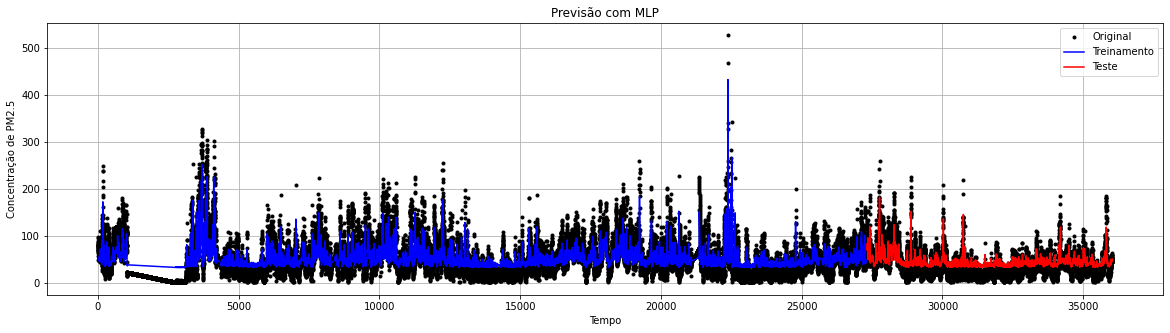

In [ ]:
plot_history_predictions(historyMLP, trainX_whole, trainY_whole, testX, testY, scaler, modelMLP, 
                         'Previsão com MLP', 'Tempo', 'Concentração de PM2.5', look_back)

# Rede RNN simples

Vamos agora projetar e ajustar nossa RNN simples.

A rede tem uma camada visível com 1 entrada, uma camada oculta com 4 blocos recorrentes ou neurônios e uma camada de saída que faz uma previsão de valor único. A função de ativação sigmóide padrão é usada para os blocos recorrentes. A rede é treinada por 20 épocas e um tamanho de lote de 1 é usado.

In [ ]:
# cria e ajusta a RNN simples 
K.clear_session()
modelRNN = Sequential()
modelRNN.add(SimpleRNN(10, activation='linear', input_shape=(look_back,data.shape[1])))
modelRNN.add(Dense(1, activation='sigmoid'))

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelRNN.compile(loss='mean_squared_error', optimizer='adam',
                    metrics=["MAE", "MSE"])

historyRNN = model.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=500, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
39/39 [==============================] - 3s 61ms/step - loss: 0.0824 - MAE: 0.2226 - MSE: 0.0824 - val_loss: 0.0114 - val_MAE: 0.0800 - val_MSE: 0.0114
Epoch 2/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0069 - MAE: 0.0619 - MSE: 0.0069 - val_loss: 0.0048 - val_MAE: 0.0520 - val_MSE: 0.0048
Epoch 3/20
39/39 [==============================] - 2s 55ms/step - loss: 0.0045 - MAE: 0.0507 - MSE: 0.0045 - val_loss: 0.0039 - val_MAE: 0.0473 - val_MSE: 0.0039
Epoch 4/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0035 - MAE: 0.0449 - MSE: 0.0035 - val_loss: 0.0028 - val_MAE: 0.0412 - val_MSE: 0.0028
Epoch 5/20
39/39 [==============================] - 2s 54ms/step - loss: 0.0026 - MAE: 0.0387 - MSE: 0.0026 - val_loss: 0.0022 - val_MAE: 0.0359 - val_MSE: 0.0022
Epoch 6/20
39/39 [==============================] - 2s 53ms/step - loss: 0.0022 - MAE: 0.0351 - MSE: 0.0022 - val_loss: 0.0022 - val_MAE: 0.0345 - val_MSE: 0.0022
Epoch 7/20
39/39 [====

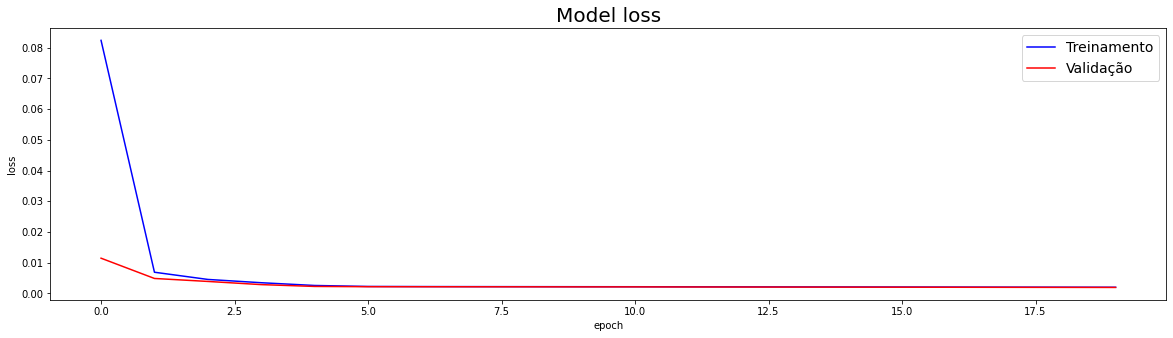

Treinamento: 23.17 RMSE
Teste: 18.92 RMSE


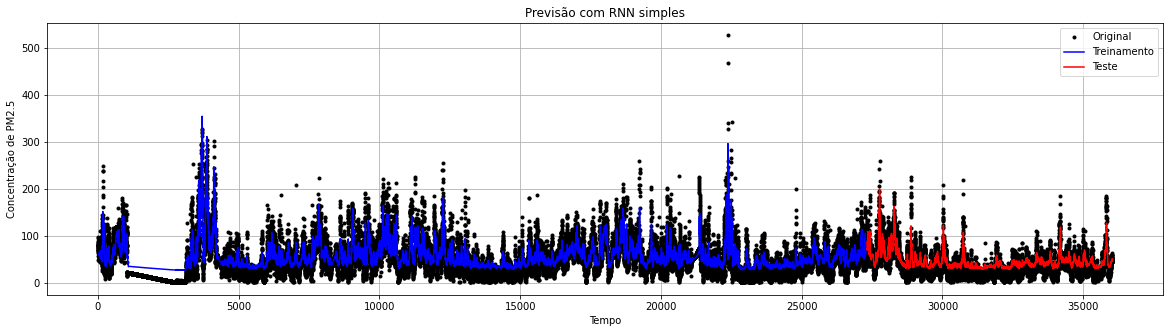

In [ ]:
plot_history_predictions(historyRNN, trainX_whole, trainY_whole, testX, testY, scaler, modelRNN, 
                         'Previsão com RNN simples', 'Tempo', 'Concentração de PM2.5', look_back)

# Rede LSTM

Vamos agora projetar e ajustar nossa rede LSTM.


In [ ]:
# cria e ajusta a rede LSTM 
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back, data.shape[1])))
modelLSTM.add(Dense(1, activation='linear'))

modelLSTM.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')

historyLSTM = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=500, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
39/39 [==============================] - 6s 127ms/step - loss: 0.0146 - val_loss: 0.0061
Epoch 2/20
39/39 [==============================] - 5s 118ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 3/20
39/39 [==============================] - 5s 118ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/20
39/39 [==============================] - 4s 115ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/20
39/39 [==============================] - 5s 117ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/20
39/39 [==============================] - 5s 123ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/20
39/39 [==============================] - 5s 120ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/20
39/39 [==============================] - 5s 118ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/20
39/39 [==============================] - 5s 117ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/20
39/39 [==============================] - 5s 117ms/step - loss: 0.0014 - val_loss: 0.0013

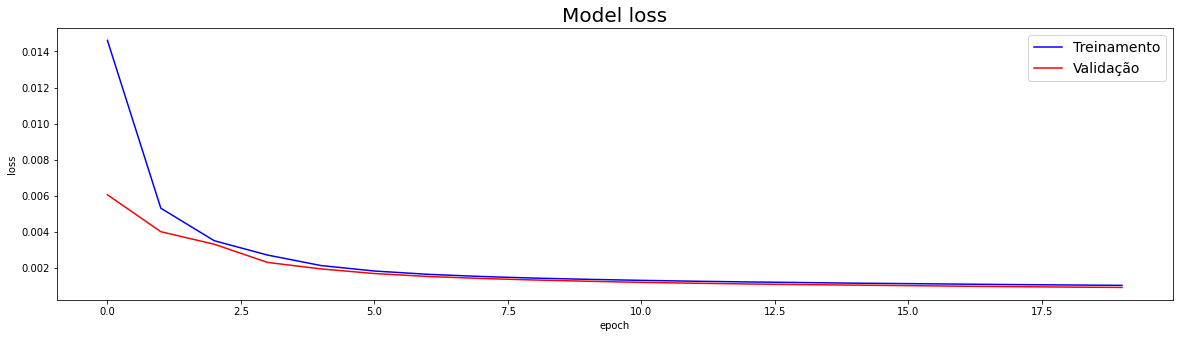

Treinamento: 16.68 RMSE
Teste: 12.07 RMSE


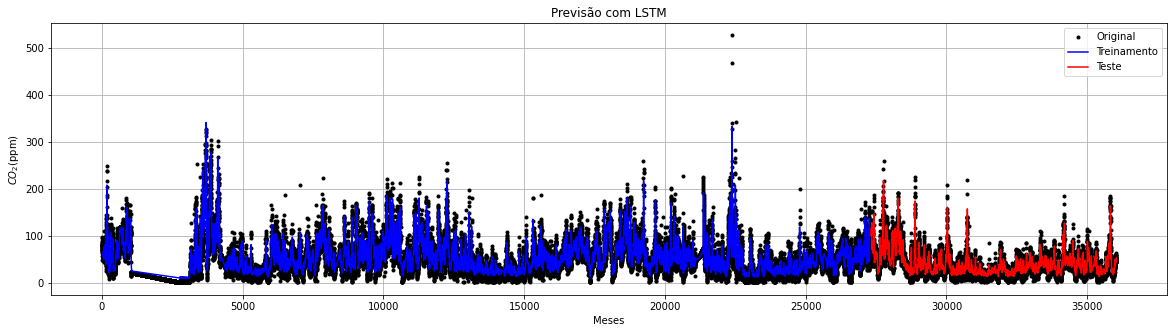

In [ ]:
plot_history_predictions(historyLSTM, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Tempo', 'Concentração de PM2.5', look_back)


## Melhoria dos resultados acima tentando o seguinte:

- Aumentar o número de épocas
- Aumentar o valor look_back
- Modificar a arquitetura
- Outros...

Como exemplo, use look_back de 5, aumente o tamanho do dataset de treinamento, aumente o número de épocas e adicione uma camada de dropout


In [ ]:
look_back = 100 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.3)


In [ ]:
# modelLSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(100, activation='linear', return_sequences = True,input_shape=(look_back, data.shape[1])))
modelLSTM.add(LSTM(50, activation='linear'))
modelLSTM.add(Dense(1))
modelLSTM.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 100, 100)          40800     
                                                                 
 lstm_16 (LSTM)              (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelLSTM.compile(loss='mean_squared_error', optimizer='adam')
historyLSTM = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=500, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
39/39 [==============================] - 59s 464ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 2/20
39/39 [==============================] - 18s 468ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/20
39/39 [==============================] - 18s 456ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/20
39/39 [==============================] - 17s 443ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/20
39/39 [==============================] - 18s 464ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 6/20
39/39 [==============================] - 18s 449ms/step - loss: 9.3140e-04 - val_loss: 9.8356e-04
Epoch 7/20
39/39 [==============================] - 18s 455ms/step - loss: 8.6100e-04 - val_loss: 9.1351e-04
Epoch 8/20
39/39 [==============================] - 18s 451ms/step - loss: 7.9728e-04 - val_loss: 8.2799e-04
Epoch 9/20
39/39 [==============================] - 18s 454ms/step - loss: 7.5764e-04 - val_loss: 7.8418e-04
Epoch 10/20
39/39 [==============================] - 18s 47

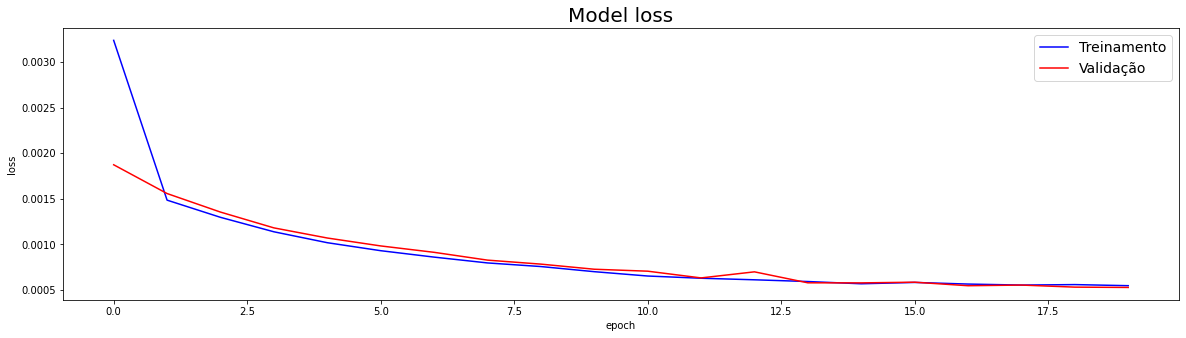

Treinamento: 12.24 RMSE
Teste: 8.22 RMSE


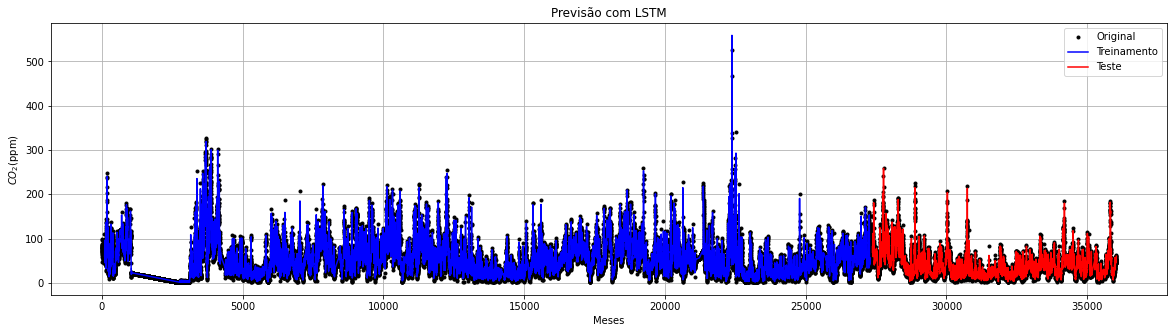

In [ ]:
plot_history_predictions(historyLSTM, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Tempo', 'Concentração de PM2.5', look_back)


# Rede GRU

Utilizar outro modelo, a GRU (Gated Recurrent Units)


In [ ]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 100 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.3)

In [ ]:
modelGRU = Sequential()
modelGRU.add(GRU(100, input_shape=(look_back, data.shape[1])))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1, activation='linear'))


In [ ]:
modelGRU.compile(loss='mean_squared_error', optimizer='adam')
historyGRU = modelGRU.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=500, 
                    verbose=1, 
                    validation_data=(valX, valY))

Epoch 1/20
39/39 [==============================] - 6s 48ms/step - loss: 0.0027 - val_loss: 9.7004e-04
Epoch 2/20
39/39 [==============================] - 1s 34ms/step - loss: 0.0010 - val_loss: 8.2094e-04
Epoch 3/20
39/39 [==============================] - 1s 35ms/step - loss: 9.1946e-04 - val_loss: 7.4319e-04
Epoch 4/20
39/39 [==============================] - 1s 38ms/step - loss: 8.3258e-04 - val_loss: 6.9080e-04
Epoch 5/20
39/39 [==============================] - 1s 35ms/step - loss: 7.8904e-04 - val_loss: 6.5963e-04
Epoch 6/20
39/39 [==============================] - 1s 35ms/step - loss: 7.4302e-04 - val_loss: 6.2197e-04
Epoch 7/20
39/39 [==============================] - 1s 35ms/step - loss: 7.0837e-04 - val_loss: 5.9503e-04
Epoch 8/20
39/39 [==============================] - 1s 34ms/step - loss: 6.7728e-04 - val_loss: 5.7481e-04
Epoch 9/20
39/39 [==============================] - 1s 35ms/step - loss: 6.6054e-04 - val_loss: 5.5979e-04
Epoch 10/20
39/39 [==========================

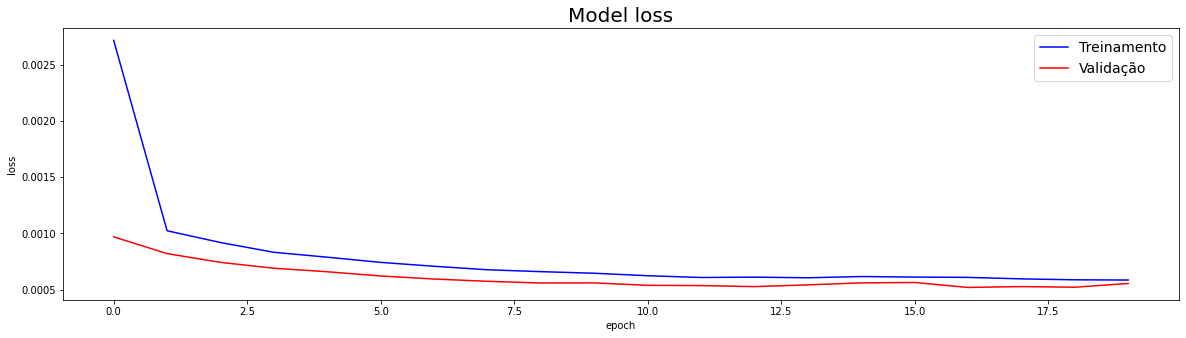

Treinamento: 12.57 RMSE
Teste: 8.26 RMSE


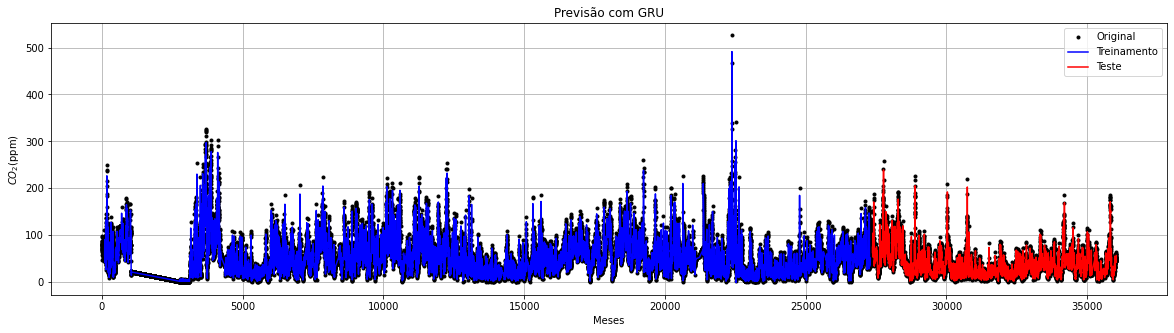

In [ ]:
plot_history_predictions(historyGRU, trainX_whole, trainY_whole, testX, testY, scaler, modelGRU, 
                         'Previsão com GRU', 'Tempo', 'Concentração de PM2.5', look_back)


# Rede CNN1D

Utilizar outro modelo, a CNN1D


In [ ]:
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=100, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1D.add(Conv1D(filters=50, kernel_size=1, activation='tanh'))
modelCNN1D.add(MaxPooling1D(pool_size=1))
modelCNN1D.add(Dropout(0.2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(50, activation='tanh'))
modelCNN1D.add(Dense(1, activation='linear'))

modelCNN1D.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 100)          200       
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 50)           5050      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 50)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense_9 (Dense)             (None, 50)                250050    
                                                     

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 500

perda = 'mae'
metrica = 'mse'

modelCNN1D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyCNN1D = modelCNN1D.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
39/39 [==============================] - 27s 39ms/step - loss: 0.0818 - mse: 0.0222 - val_loss: 0.0218 - val_mse: 0.0011
Epoch 2/20
39/39 [==============================] - 1s 18ms/step - loss: 0.0198 - mse: 9.2433e-04 - val_loss: 0.0168 - val_mse: 6.7347e-04
Epoch 3/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0171 - mse: 7.4133e-04 - val_loss: 0.0217 - val_mse: 9.3850e-04
Epoch 4/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0172 - mse: 7.3184e-04 - val_loss: 0.0184 - val_mse: 7.2952e-04
Epoch 5/20
39/39 [==============================] - 1s 18ms/step - loss: 0.0164 - mse: 6.7004e-04 - val_loss: 0.0149 - val_mse: 5.5875e-04
Epoch 6/20
39/39 [==============================] - 1s 18ms/step - loss: 0.0157 - mse: 6.3567e-04 - val_loss: 0.0149 - val_mse: 5.4594e-04
Epoch 7/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0156 - mse: 6.3585e-04 - val_loss: 0.0183 - val_mse: 7.0874e-04
Epoch 8/20
39/39 [================

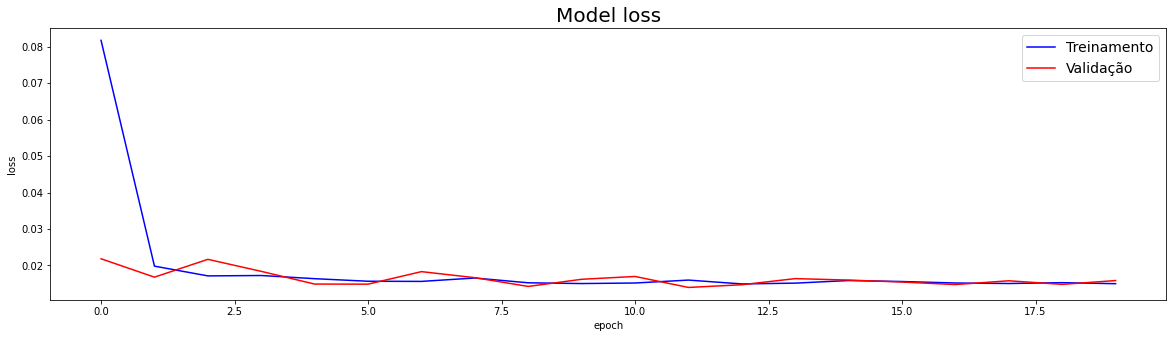

Treinamento: 13.09 RMSE
Teste: 8.72 RMSE


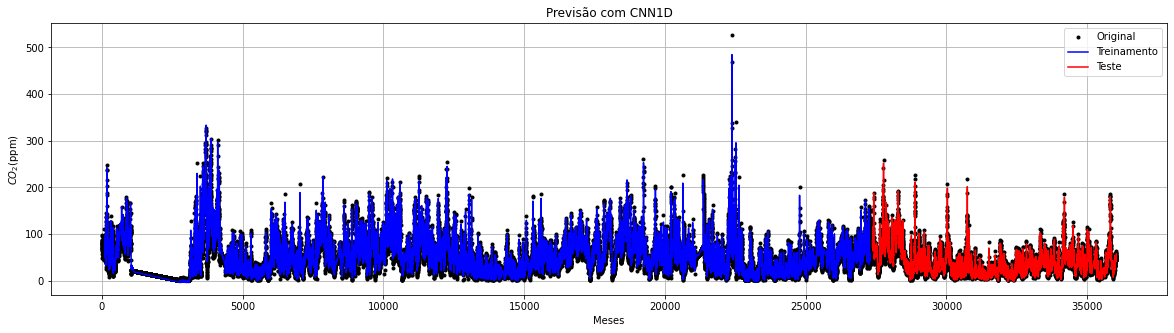

In [ ]:
plot_history_predictions(historyCNN1D, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1D, 
                         'Previsão com CNN1D', 'Tempo', 'Concentração de PM2.5', look_back)


# Rede FCN-LSTM
### Abordagem híbrida: chamada muitas vezes de CNN-LSTM, FCN-LSTM ou FC-LSTM


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes.
Nesta primeira parte, vamos criar uma rede que combina operações de convolução, para depois enviar as principais características retornadas para uma camada LSTM. Esta abordagem é chamada muitas vezes de CNN-LSTM, FCN-LSTM ou FC-LSTM.


In [ ]:
modelCNN1DLSTM = Sequential()
modelCNN1DLSTM.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTM.add(MaxPooling1D(pool_size=1))

modelCNN1DLSTM.add(LSTM(100))
modelCNN1DLSTM.add(Dropout(0.2))

modelCNN1DLSTM.add(Flatten())

modelCNN1DLSTM.add(Dense(10, activation='tanh'))
modelCNN1DLSTM.add(Dense(1, activation='linear'))

modelCNN1DLSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 50, 128)           256       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 50, 128)          0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               91600     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 flatten_2 (Flatten)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                      

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 500

perda = 'mae'
metrica = 'mse'

modelCNN1DLSTM.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyCNN1DLSTM = modelCNN1DLSTM.fit(trainX, trainY, epochs=epochs, verbose=verbose, 
                             validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
39/39 [==============================] - 6s 55ms/step - loss: 0.0272 - mse: 0.0017 - val_loss: 0.0177 - val_mse: 7.7516e-04
Epoch 2/20
39/39 [==============================] - 1s 36ms/step - loss: 0.0175 - mse: 7.9638e-04 - val_loss: 0.0154 - val_mse: 6.2919e-04
Epoch 3/20
39/39 [==============================] - 1s 36ms/step - loss: 0.0160 - mse: 6.8616e-04 - val_loss: 0.0145 - val_mse: 5.7260e-04
Epoch 4/20
39/39 [==============================] - 1s 35ms/step - loss: 0.0153 - mse: 6.3111e-04 - val_loss: 0.0141 - val_mse: 5.4362e-04
Epoch 5/20
39/39 [==============================] - 1s 35ms/step - loss: 0.0150 - mse: 6.0789e-04 - val_loss: 0.0138 - val_mse: 5.3464e-04
Epoch 6/20
39/39 [==============================] - 1s 35ms/step - loss: 0.0148 - mse: 6.0344e-04 - val_loss: 0.0138 - val_mse: 5.2387e-04
Epoch 7/20
39/39 [==============================] - 1s 35ms/step - loss: 0.0146 - mse: 5.9152e-04 - val_loss: 0.0137 - val_mse: 5.2089e-04
Epoch 8/20
39/39 [=============

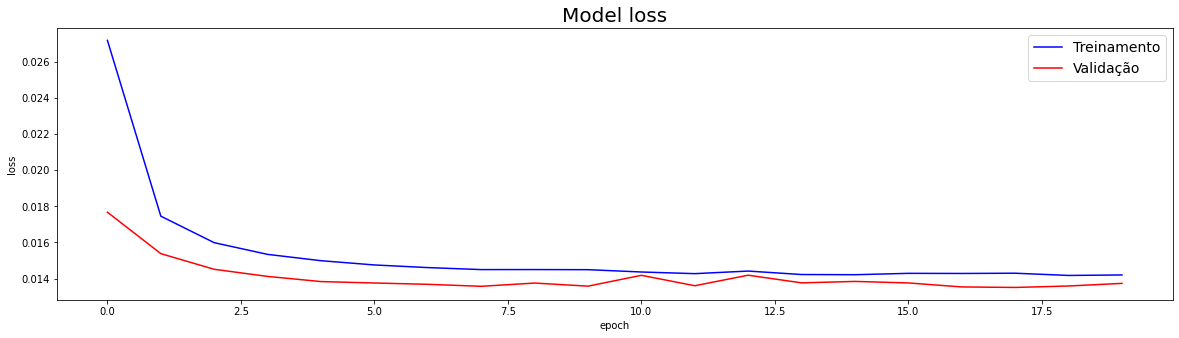

Treinamento: 12.37 RMSE
Teste: 8.09 RMSE


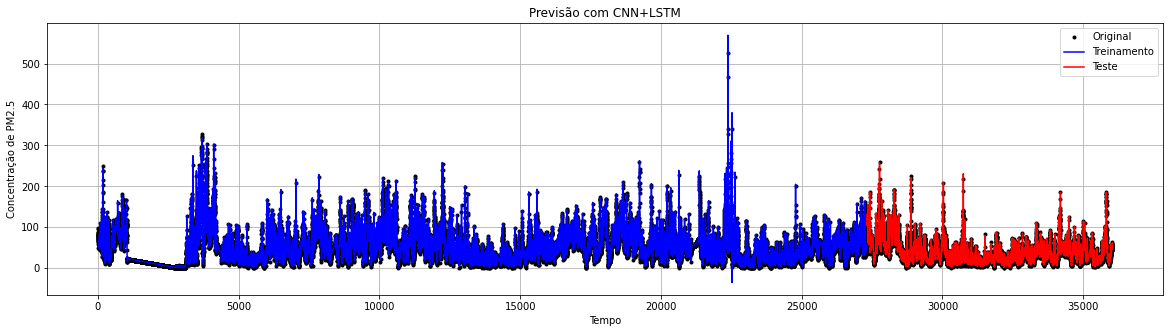

In [ ]:
plot_history_predictions(historyCNN1DLSTM, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTM, 
                         'Previsão com CNN+LSTM', 'Tempo', 'Concentração de PM2.5', look_back)

# Rede Conv2DLSTM


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes: a Conv2DLSTM


In [ ]:
trainX.shape


(19057, 50, 1)

In [ ]:
trainX2D = trainX.reshape((trainX.shape[0], trainX.shape[1], 1, trainX.shape[2], 1))
valX2D = valX.reshape((valX.shape[0], valX.shape[1], 1, valX.shape[2], 1))
trainX2D.shape

(19057, 50, 1, 1, 1)

In [ ]:
modelConvLSTM2D = Sequential()

modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True,
                           input_shape=(look_back, trainX2D.shape[2], trainX2D.shape[3], trainX2D.shape[4])))
modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True))
modelConvLSTM2D.add(MaxPooling3D(pool_size=(look_back,1,1)))
modelConvLSTM2D.add(Dropout(0.2))
modelConvLSTM2D.add(Flatten())
modelConvLSTM2D.add(Dense(10, activation='tanh'))
modelConvLSTM2D.add(Dense(1, activation='linear'))


In [ ]:
tx = 0.001
verbose = 1
epochs = 3
batch_size = 2000

perda = 'mae'
metrica = 'mse'

modelConvLSTM2D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyConvLSTM2D = modelConvLSTM2D.fit(trainX2D, trainY, epochs=epochs, verbose=verbose, validation_data=(valX2D, valY), 
                              batch_size=batch_size)

Epoch 1/3
10/10 [==============================] - 102s 10s/step - loss: 0.0510 - mse: 0.0051 - val_loss: 0.0404 - val_mse: 0.0034
Epoch 2/3
10/10 [==============================] - 97s 10s/step - loss: 0.0391 - mse: 0.0032 - val_loss: 0.0370 - val_mse: 0.0029
Epoch 3/3
10/10 [==============================] - 97s 10s/step - loss: 0.0365 - mse: 0.0029 - val_loss: 0.0339 - val_mse: 0.0025


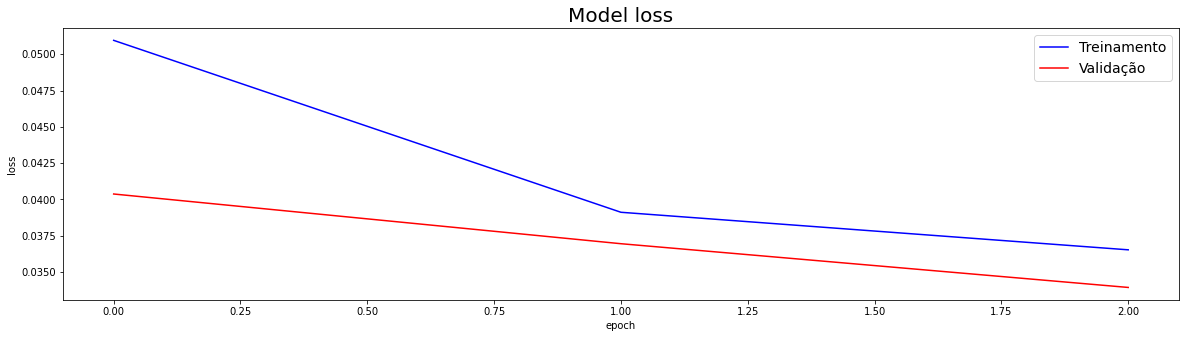

Treinamento: 26.46 RMSE
Teste: 19.73 RMSE


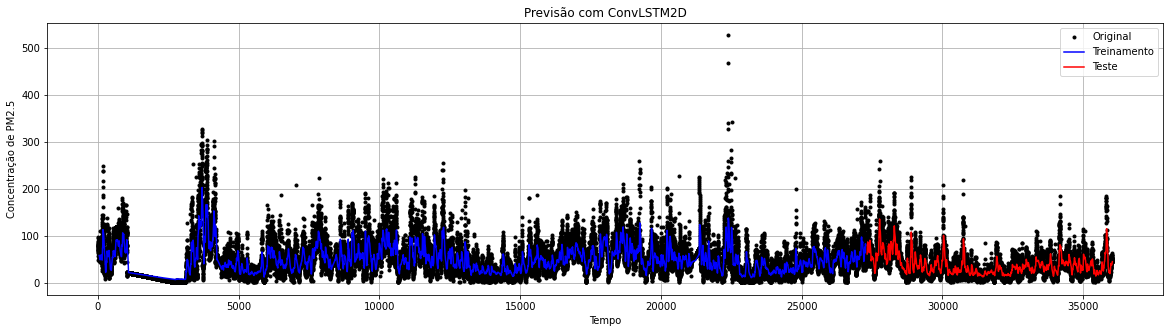

In [ ]:
trainX2D_whole = trainX_whole.reshape((trainX_whole.shape[0], trainX_whole.shape[1], 1, trainX_whole.shape[2], 1))
testX2D = testX.reshape((testX.shape[0], testX.shape[1], 1, testX.shape[2], 1))


plot_history_predictions(historyConvLSTM2D, trainX2D_whole, trainY_whole, testX2D, testY, scaler, modelConvLSTM2D, 
                         'Previsão com ConvLSTM2D', 'Tempo', 'Concentração de PM2.5', look_back)

# TimeDistributed


Vamos aprender a utilizar a camada TimeDistributed <p>
Para tal, vamos configurar uma rede sem, e outra com, a camada TimeDistributed, e vamos comparar o desempenho de ambas.
    
Fonte: https://keras.io/api/layers/recurrent_layers/time_distributed/


In [ ]:
#Rede FCN+LSTM sem TimeDistributed
modelCNN1DLSTMSemTD = Sequential()
modelCNN1DLSTMSemTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMSemTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMSemTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMSemTD.add(Dense(10, activation='tanh'))
modelCNN1DLSTMSemTD.add(Dense(1, activation='linear'))

modelCNN1DLSTMSemTD.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 128)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 50, 16)            9280      
                                                                 
 dense_3 (Dense)             (None, 50, 10)            170       
                                                                 
 dense_4 (Dense)             (None, 50, 1)             11        
                                                                 
Total params: 9,717
Trainable params: 9,717
Non-trainable params: 0
____________________________________________________

In [ ]:
#Rede FCN+LSTM com TimeDistributed
modelCNN1DLSTMTD = Sequential()
modelCNN1DLSTMTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(10, activation='tanh')))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(1, activation='linear')))

modelCNN1DLSTMTD.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 50, 128)           256       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 50, 16)            9280      
                                                                 
 time_distributed (TimeDistr  (None, 50, 10)           170       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 1)            11        
 tributed)                                                       
                                                      

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 500

perda = 'mae'
metrica = 'mse'

#treinando a rede sem TimeDistributed
modelCNN1DLSTMSemTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historySemTD = modelCNN1DLSTMSemTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
39/39 [==============================] - 4s 43ms/step - loss: 0.0469 - mse: 0.0045 - val_loss: 0.0407 - val_mse: 0.0037
Epoch 2/20
39/39 [==============================] - 1s 29ms/step - loss: 0.0405 - mse: 0.0037 - val_loss: 0.0399 - val_mse: 0.0036
Epoch 3/20
39/39 [==============================] - 1s 24ms/step - loss: 0.0396 - mse: 0.0036 - val_loss: 0.0395 - val_mse: 0.0034
Epoch 4/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0392 - mse: 0.0035 - val_loss: 0.0391 - val_mse: 0.0034
Epoch 5/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0390 - mse: 0.0035 - val_loss: 0.0390 - val_mse: 0.0034
Epoch 6/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0390 - mse: 0.0035 - val_loss: 0.0391 - val_mse: 0.0034
Epoch 7/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0389 - mse: 0.0035 - val_loss: 0.0390 - val_mse: 0.0035
Epoch 8/20
39/39 [==============================] - 1s 23ms/step - loss: 0.0389 - m

In [ ]:
# treinando a rede com TimeDistributed
modelCNN1DLSTMTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyTD = modelCNN1DLSTMTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
39/39 [==============================] - 4s 38ms/step - loss: 0.0476 - mse: 0.0047 - val_loss: 0.0408 - val_mse: 0.0038
Epoch 2/20
39/39 [==============================] - 1s 22ms/step - loss: 0.0405 - mse: 0.0037 - val_loss: 0.0401 - val_mse: 0.0036
Epoch 3/20
39/39 [==============================] - 1s 20ms/step - loss: 0.0399 - mse: 0.0036 - val_loss: 0.0397 - val_mse: 0.0035
Epoch 4/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0395 - mse: 0.0036 - val_loss: 0.0394 - val_mse: 0.0034
Epoch 5/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0393 - mse: 0.0035 - val_loss: 0.0392 - val_mse: 0.0034
Epoch 6/20
39/39 [==============================] - 1s 20ms/step - loss: 0.0392 - mse: 0.0035 - val_loss: 0.0391 - val_mse: 0.0034
Epoch 7/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0391 - mse: 0.0035 - val_loss: 0.0397 - val_mse: 0.0033
Epoch 8/20
39/39 [==============================] - 1s 19ms/step - loss: 0.0392 - m

In [ ]:
#vamos ver o shape retornado do predict da rede com e sem TimeDistributed
tsTD=modelCNN1DLSTMSemTD.predict(testX);
print(tsTD.shape, len(tsTD.shape))

tTD=modelCNN1DLSTMTD.predict(testX);
print(tTD.shape, len(tTD.shape))


(8710, 50, 1) 3
(8710, 50, 1) 3


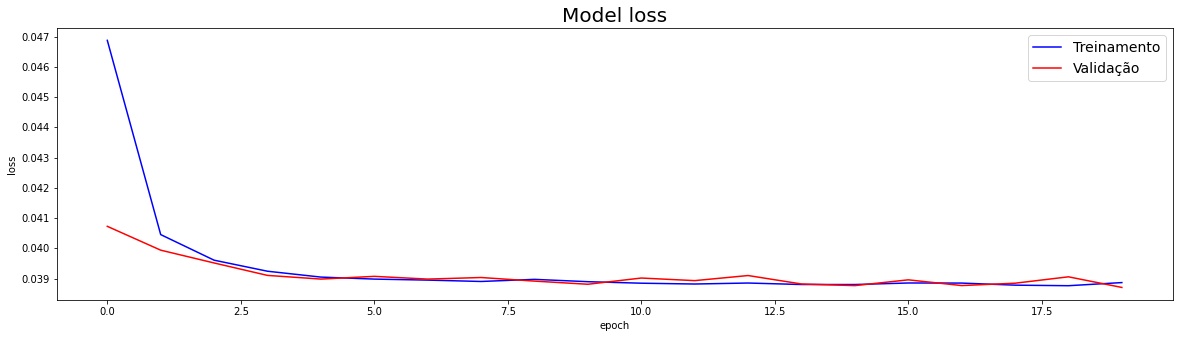

Treinamento: 19.85 RMSE
Teste: 13.01 RMSE


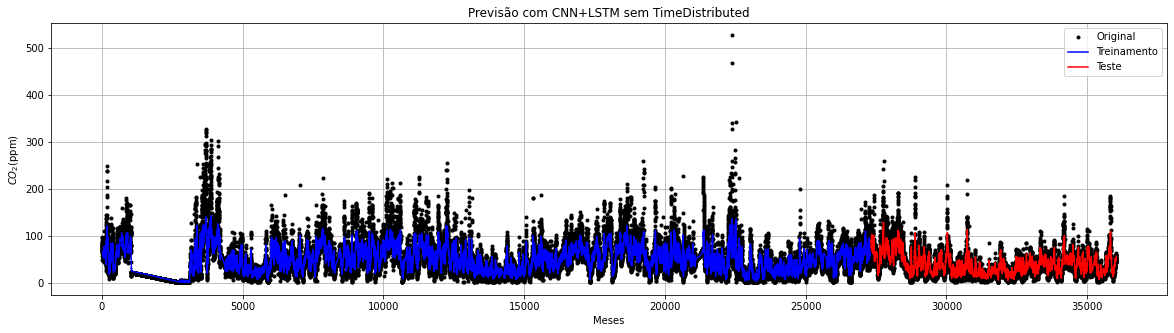

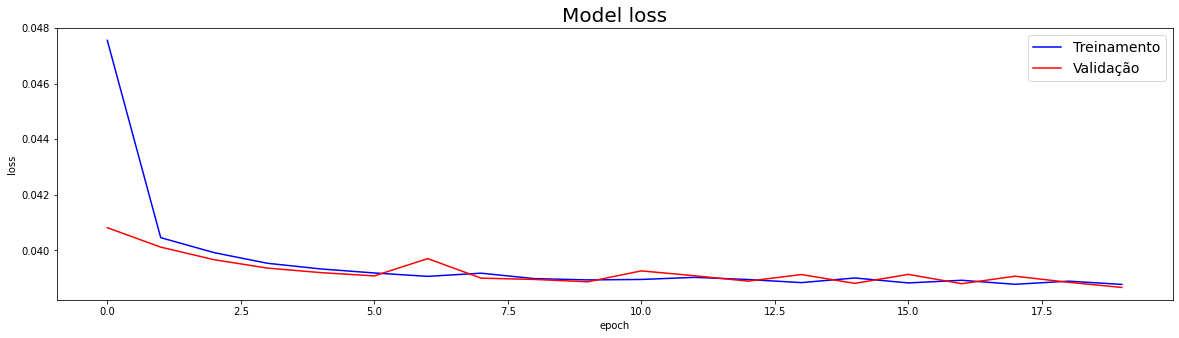

Treinamento: 19.60 RMSE
Teste: 12.73 RMSE


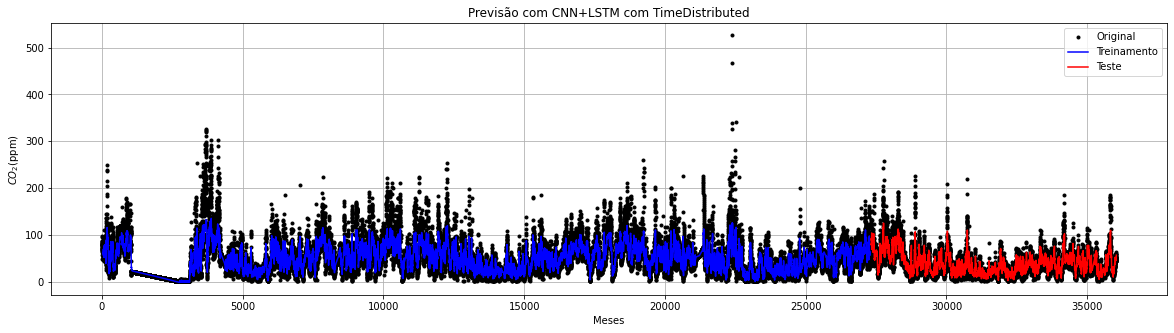

In [ ]:
plot_history_predictions(historySemTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMSemTD, 
                         'Previsão com CNN+LSTM sem TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)

plot_history_predictions(historyTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMTD, 
                         'Previsão com CNN+LSTM com TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)



# Bônus
## BÔNUS: utilizar as informações meteorológicas para melhorar a qualidade dos modelos finais

# Discussão dos Resultados

##\\ ...espaço para discussão dos resultados

precisamos descrever um modelo de cada vez, justificando as escolha dos hiperparametros e das camada selecionadas, explicando como e porque eles ajudaram a melhorar os resultados do modelo.
Depois comentar sobre o modelo que obteve o melhor resultado;
Depois comentar sobre o modelo que obteve melhor custo beneficio, ou seja, bom resultado com baixo custo computacional

MLP

RNN

LSTM

GRU

....